In [78]:
!pip install folktables

You should consider upgrading via the '/home/denys_herasymuk/UCU/Studying_abroad/NYU_Internship/Code/RAI-summer-stability/RAI_venv/bin/python -m pip install --upgrade pip' command.


In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
import sys
import sklearn
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from utils.model_tuning_utils import test_ML_models

In [81]:
%matplotlib inline

plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = 15, 5

import warnings
warnings.filterwarnings('ignore')

### Python & Library Versions

In [82]:
versions = ( ("matplotlib", matplotlib.__version__),
             ("numpy", np.__version__),
             ("pandas", pd.__version__),
             ("sklearn", sklearn.__version__),
             ("seaborn", sns.__version__)
             )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))


3.8.10 (default, Mar 15 2022, 12:22:08) 
[GCC 9.4.0] 

library    version
------------------
matplotlib  3.5.2
numpy       1.21.2
pandas      1.3.3
sklearn     1.1.1
seaborn     0.11.2


### Read a dataset

In [83]:
from folktables import ACSDataSource, ACSEmployment

data_source = ACSDataSource(survey_year='2016', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSEmployment.df_to_numpy(acs_data)

### Data Pre-processing

In [84]:
ACSEmployment.target

'ESR'

In [85]:
ACSEmployment.features

['AGEP',
 'SCHL',
 'MAR',
 'RELP',
 'DIS',
 'ESP',
 'CIT',
 'MIG',
 'MIL',
 'ANC',
 'NATIVITY',
 'DEAR',
 'DEYE',
 'DREM',
 'SEX',
 'RAC1P']

In [86]:
features.shape, acs_data.shape

((376035, 16), (376035, 284))

In [87]:
# Create pandas datafrane with features and label column
full_df = acs_data[ACSEmployment.features + [ACSEmployment.target]].copy()
full_df.head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,68,20.0,1,0,2,NaN,4,1.0,4.0,1,2,2,2,2.0,2,9,6.0
1,75,18.0,1,1,2,NaN,4,1.0,2.0,1,2,2,2,2.0,1,9,6.0
2,50,19.0,1,0,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,9,1.0
3,49,16.0,1,1,2,NaN,1,1.0,4.0,1,1,2,2,2.0,1,1,1.0
4,22,18.0,5,2,2,NaN,1,1.0,4.0,1,1,2,2,2.0,1,9,3.0


In [88]:
# Convert label column to binary format
full_df['LABEL_ESR'] = ACSEmployment.target_transform(full_df[ACSEmployment.target])
full_df.drop([ACSEmployment.target], axis=1, inplace=True)

In [89]:
full_df['AGEP'].describe()

count    376035.000000
mean         39.918162
std          23.203014
min           0.000000
25%          20.000000
50%          40.000000
75%          58.000000
max          94.000000
Name: AGEP, dtype: float64

### Checking If Nulls Mean a Separate Category

In [90]:
full_df.isnull().sum()

AGEP              0
SCHL          11466
MAR               0
RELP              0
DIS               0
ESP          300716
CIT               0
MIG            3702
MIL           74731
ANC               0
NATIVITY          0
DEAR              0
DEYE              0
DREM          19605
SEX               0
RAC1P             0
LABEL_ESR         0
dtype: int64

In [91]:
# Percentage of nulls in each column
full_df.isnull().sum() / full_df.shape[0]

AGEP         0.000000
SCHL         0.030492
MAR          0.000000
RELP         0.000000
DIS          0.000000
ESP          0.799702
CIT          0.000000
MIG          0.009845
MIL          0.198734
ANC          0.000000
NATIVITY     0.000000
DEAR         0.000000
DEYE         0.000000
DREM         0.052136
SEX          0.000000
RAC1P        0.000000
LABEL_ESR    0.000000
dtype: float64

#### SCHL Nulls Analysis

**Hypothesis:** N/A (less than 3 years old)

In [94]:
full_df['AGEP'].value_counts()

55    5532
60    5513
56    5384
58    5369
52    5369
      ... 
86    1144
87     983
88     878
89     771
90     745
Name: AGEP, Length: 92, dtype: int64

In [98]:
full_df['AGEP'][full_df['AGEP'] < 3].count()

11466

In [97]:
full_df['SCHL'].isnull().sum()

11466

#### ESP Nulls Analysis

**Hypothesis:** N/A (not own child of householder, and not child in subfamily).

In [106]:
full_df['ESP'].isnull().sum()

300716

In [137]:
full_df['ESP'][(full_df['RELP'] != 2) & (full_df['RELP'] != 3) & (full_df['RELP'] != 4) & (full_df['RELP'] != 7) & (full_df['RELP'] != 14)].count()

1687

In [138]:
full_df['ESP'][(full_df['ESP'].isnull()) & (full_df['RELP'] != 2) & (full_df['RELP'] != 3)
                & (full_df['RELP'] != 4) & (full_df['RELP'] != 7) & (full_df['RELP'] != 14)].count()

0

In [110]:
full_df['RELP'][(full_df['RELP'] == 2) | (full_df['RELP'] == 3) | (full_df['RELP'] == 4) | (full_df['RELP'] == 7) | (full_df['RELP'] == 14)].count()

113815

In [136]:
full_df['ESP'][(full_df['ESP'].isnull()) & ( (full_df['RELP'] == 2) | (full_df['RELP'] == 3)
                                      | (full_df['RELP'] == 4) | (full_df['RELP'] == 7) | (full_df['RELP'] == 14) )].count()

0

In [133]:
full_df[(full_df['ESP'].isnull()) & ( (full_df['RELP'] == 2) | (full_df['RELP'] == 3)
                | (full_df['RELP'] == 4) | (full_df['RELP'] == 7) | (full_df['RELP'] == 14) )].apply(pd.Series.value_counts)

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,LABEL_ESR
0.0,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17453.0
False,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17453.0
1.0,79,463.0,2660.0,NaN,3558.0,NaN,33782.0,36289.0,14.0,24370.0,34583.0,416.0,539.0,2246.0,21754.0,22538.0,22730.0
True,79,463.0,2660.0,NaN,3558.0,NaN,33782.0,36289.0,14.0,24370.0,34583.0,416.0,539.0,2246.0,21754.0,22538.0,22730.0
2.0,63,66.0,169.0,34548.0,36625.0,NaN,40.0,175.0,587.0,9253.0,5600.0,39767.0,39644.0,37607.0,18429.0,2426.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72.0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73.0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
full_df[full_df['ESP'].isnull()]['AGEP'].value_counts()

55    5532
60    5513
56    5384
58    5369
52    5369
      ... 
4      166
5      156
1      152
2      146
3      146
Name: AGEP, Length: 92, dtype: int64

In [129]:
full_df[full_df['ESP'].isnull()]['RELP'].value_counts()

0     132809
1      68428
2      34548
13      8159
17      7877
16      7599
6       6772
12      6631
10      5909
5       5127
15      4444
7       3193
11      2792
9       2266
8       1720
4       1473
3        662
14       307
Name: RELP, dtype: int64

In [126]:
full_df[full_df['ESP'].isnull()][[column for column in full_df.columns if column != 'AGEP']].apply(pd.Series.value_counts)

,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,LABEL_ESR
0.0,NaN,NaN,132809.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134295.0
False,NaN,NaN,132809.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134295.0
True,8400.0,153381.0,68428.0,45204.0,NaN,200996.0,260987.0,1378.0,191098.0,205239.0,13017.0,8265.0,16937.0,146953.0,188735.0,166421.0
1.0,8400.0,153381.0,68428.0,45204.0,NaN,200996.0,260987.0,1378.0,191098.0,205239.0,13017.0,8265.0,16937.0,146953.0,188735.0,166421.0
2.0,222.0,17198.0,34548.0,255512.0,NaN,702.0,2434.0,18088.0,67857.0,95477.0,287699.0,292451.0,283001.0,153763.0,15790.0,NaN
3.0,329.0,29275.0,662.0,NaN,NaN,3541.0,37127.0,2532.0,3281.0,NaN,NaN,NaN,NaN,NaN,2076.0,NaN
4.0,534.0,5794.0,1473.0,NaN,NaN,53398.0,NaN,274998.0,38480.0,NaN,NaN,NaN,NaN,NaN,30.0,NaN
5.0,935.0,95068.0,5127.0,NaN,NaN,42079.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,701.0,NaN
6.0,1797.0,NaN,6772.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46899.0,NaN
7.0,1216.0,NaN,3193.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1083.0,NaN


#### MIG Nulls Analysis

**Hypothesis:** N/A (less than 1 year old).

In [99]:
full_df['MIG'].isnull().sum()

3702

In [100]:
full_df['AGEP'][full_df['AGEP'] < 1].count()

3702

#### MIL Nulls Analysis

**Hypothesis:** N/A (less than 17 years old).

In [101]:
full_df['MIL'].isnull().sum()

74731

In [102]:
full_df['AGEP'][full_df['AGEP'] < 17].count()

74731

#### DREM Nulls Analysis

**Hypothesis:** N/A (less than 5 years old).

In [103]:
full_df['DREM'].isnull().sum()

19605

In [105]:
full_df['AGEP'][full_df['AGEP'] < 5].count()

19605

**Conclusion:** all hypotheses are proved -- all columns, which contain nulls, can be encoded with an extra category.

Encode nulls for a separate category

In [62]:
# full_df.fillna(0, inplace = True)
# full_df.isnull().sum()

AGEP         0
SCHL         0
MAR          0
RELP         0
DIS          0
ESP          0
CIT          0
MIG          0
MIL          0
ANC          0
NATIVITY     0
DEAR         0
DEYE         0
DREM         0
SEX          0
RAC1P        0
LABEL_ESR    0
dtype: int64

### Data Profiling

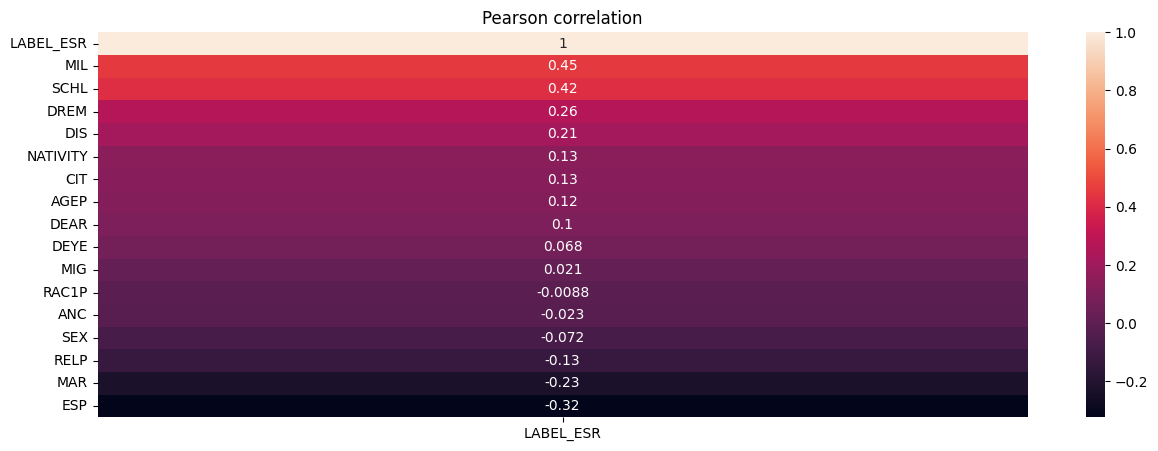

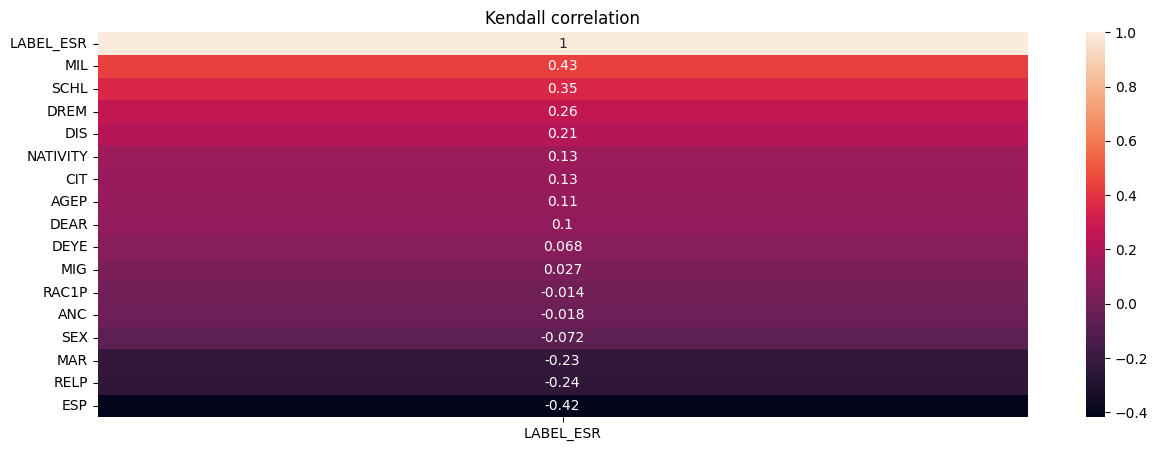

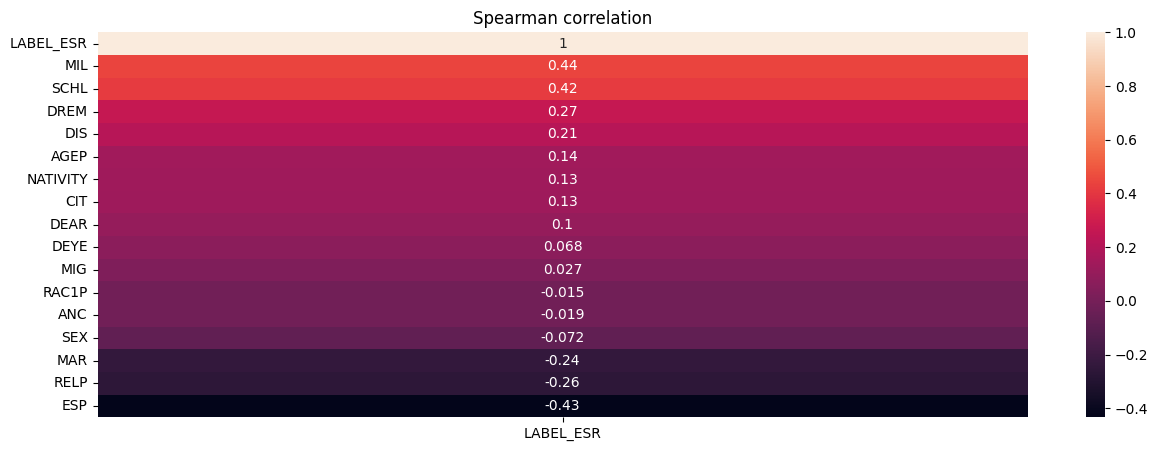

In [63]:
# Look at the feature correlation with 'LABEL_ESR' column
for method in ['pearson', 'kendall', 'spearman']:
    ax = plt.axes()
    sns.heatmap(
        full_df.corr(method=method)[['LABEL_ESR']]\
            .sort_values(by='LABEL_ESR', ascending=False),
        ax=ax,
        annot=True
    )
    ax.set_title(f'{method.capitalize()} correlation')
    plt.show()


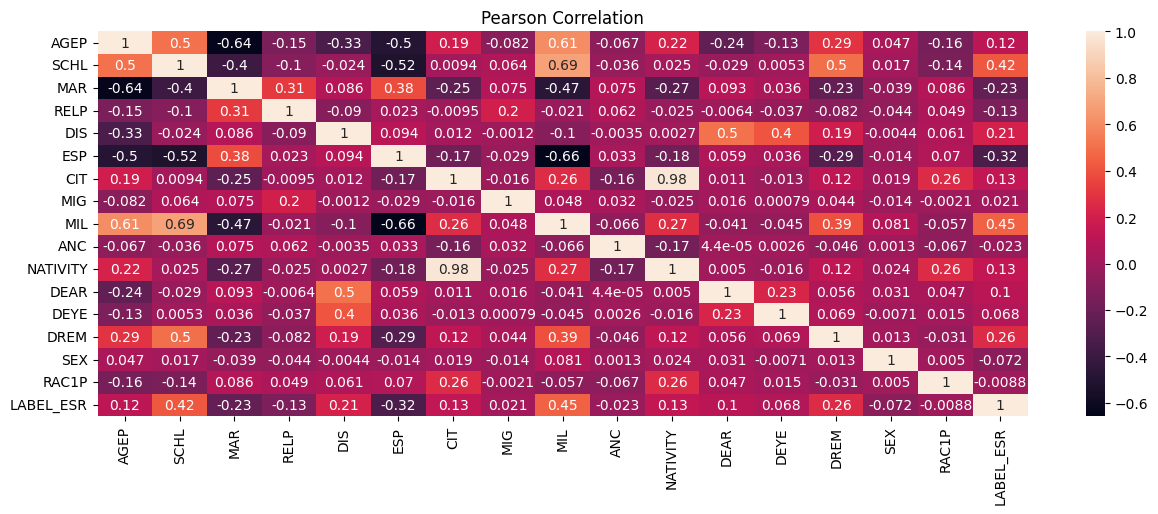

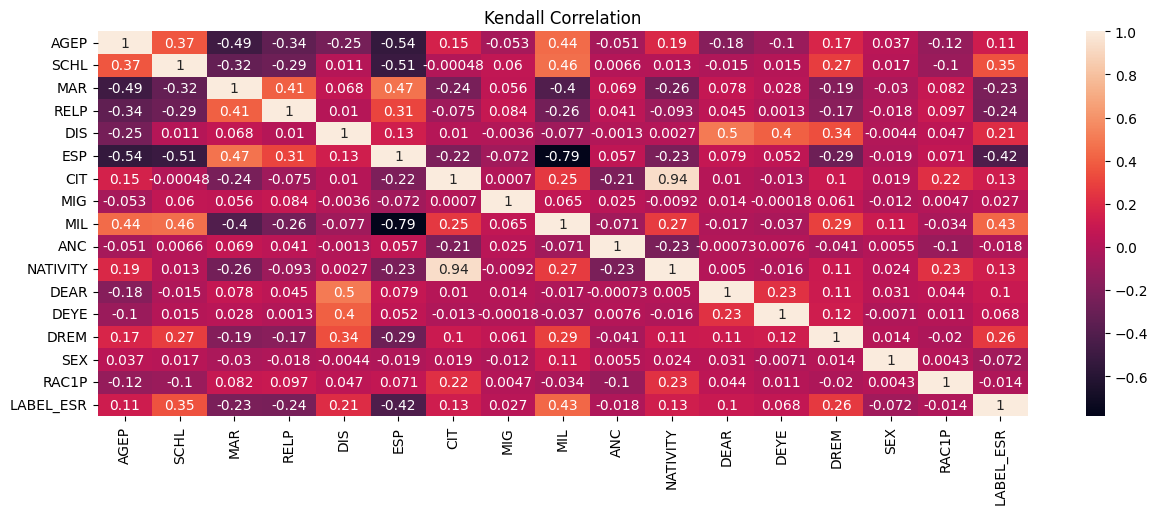

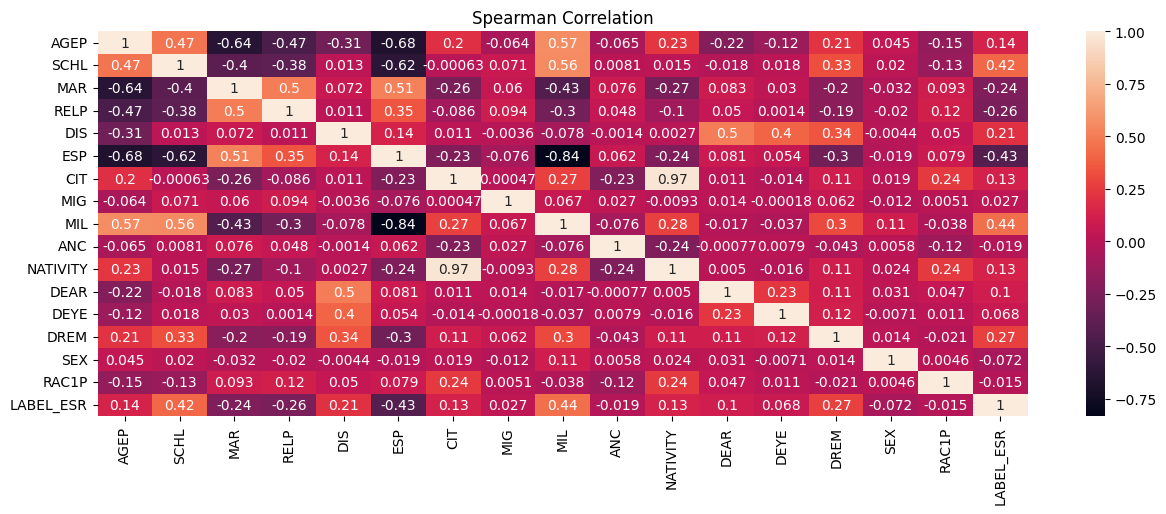

In [64]:
# Look at correlations among features
for method in ['pearson', 'kendall', 'spearman']:
    ax = plt.axes()
    sns.heatmap(full_df.corr(method=method), ax=ax, annot=True)
    ax.set_title(f'{method.capitalize()} Correlation')
    plt.show()


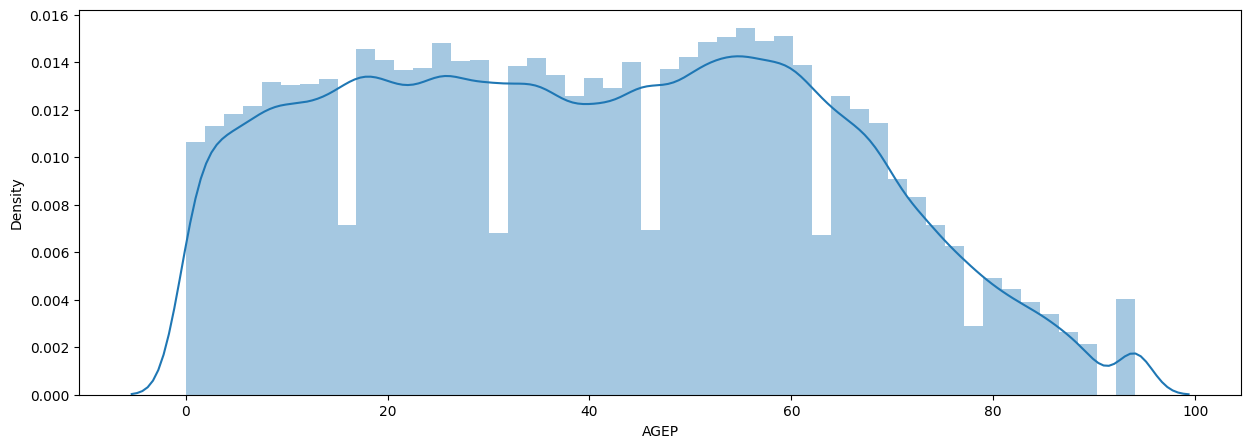

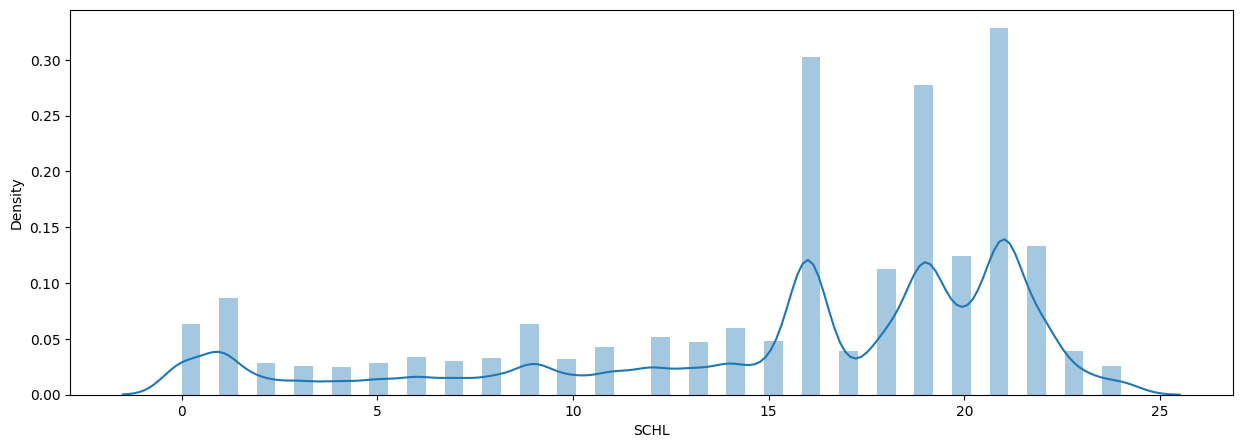

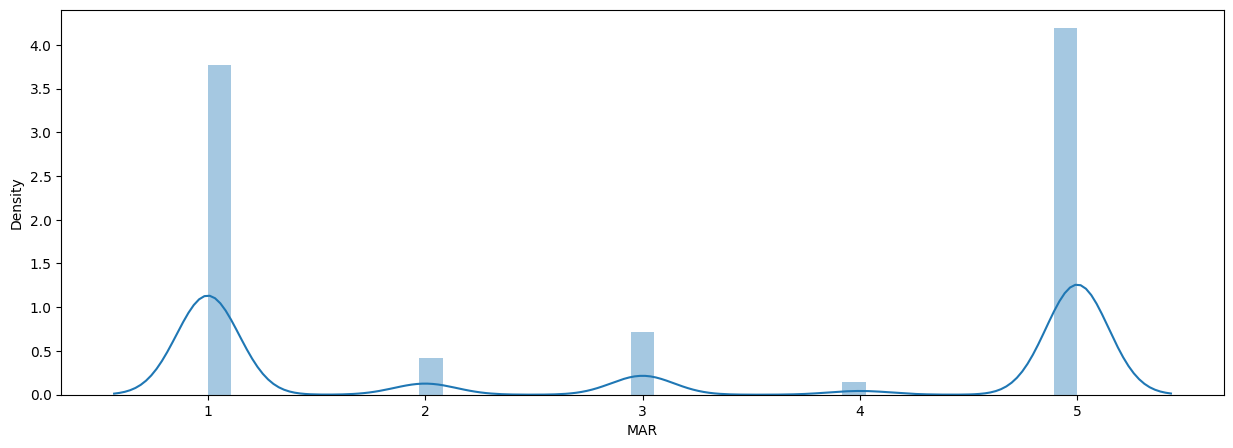

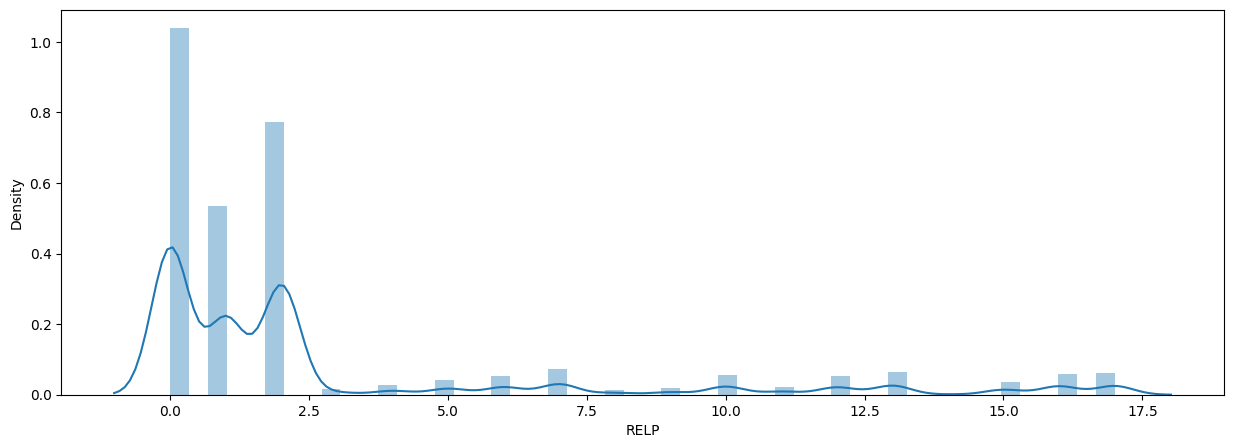

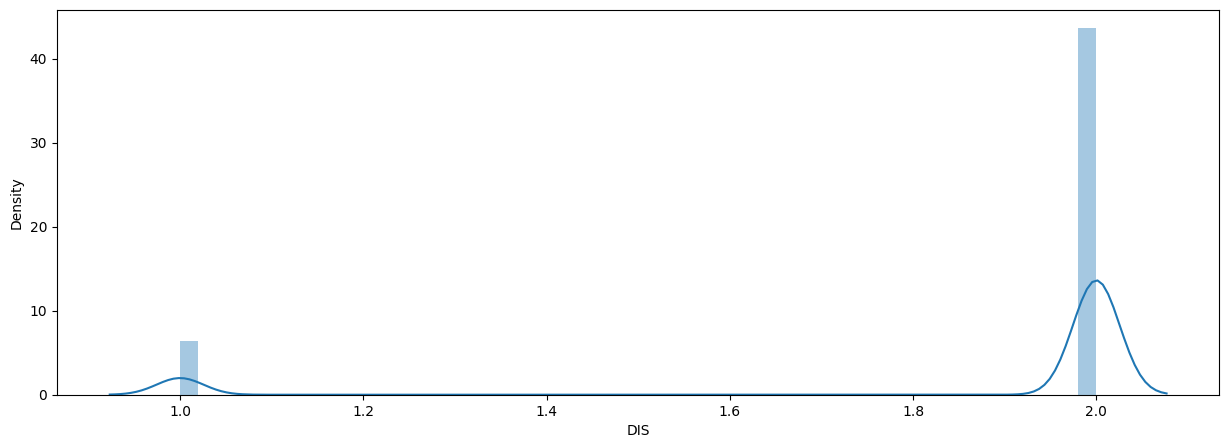

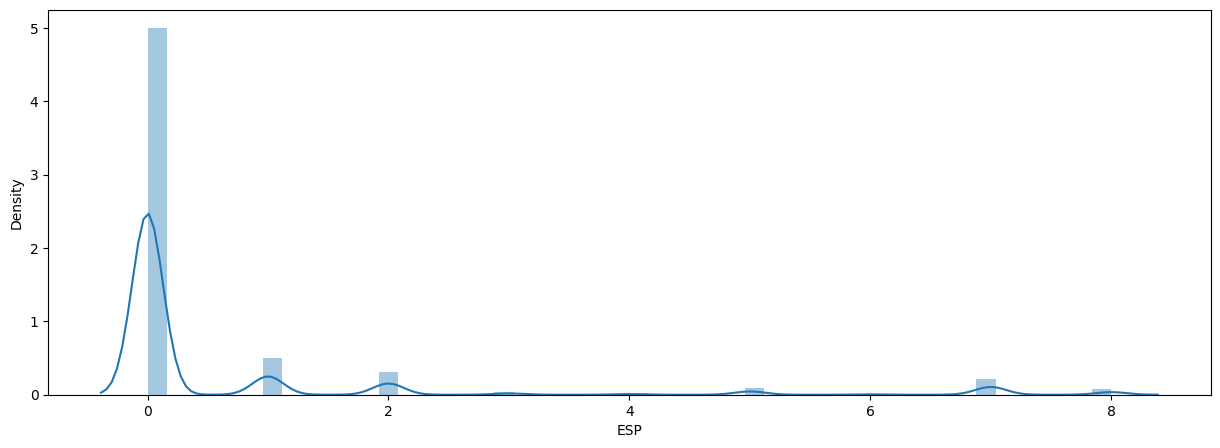

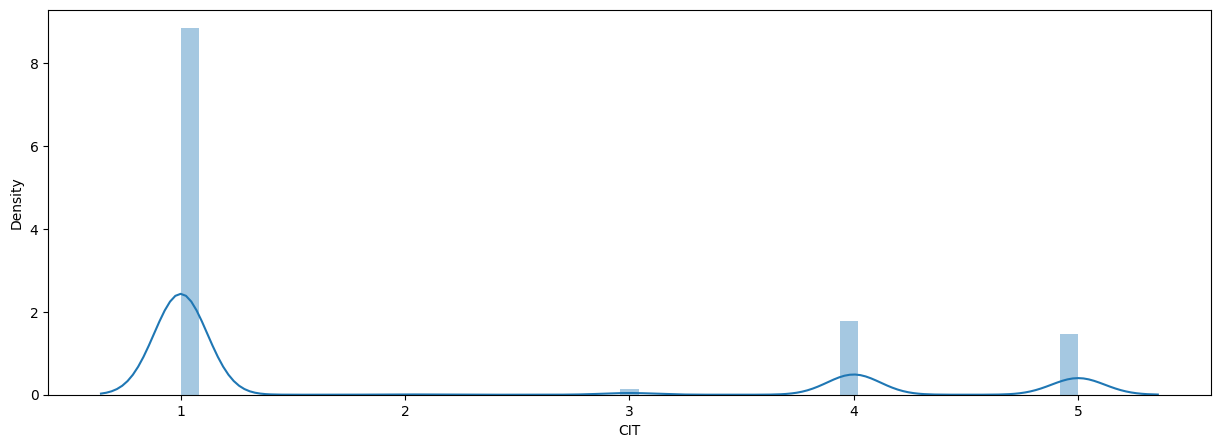

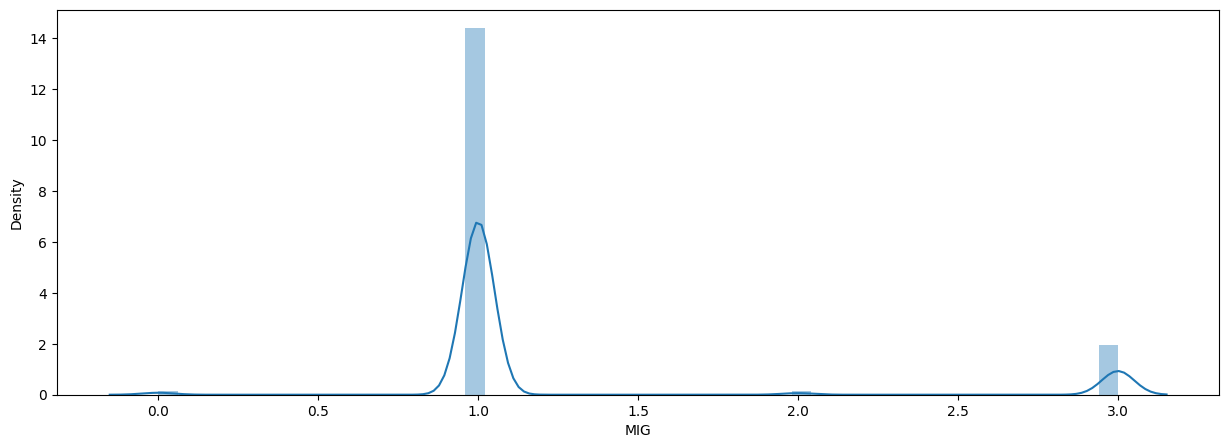

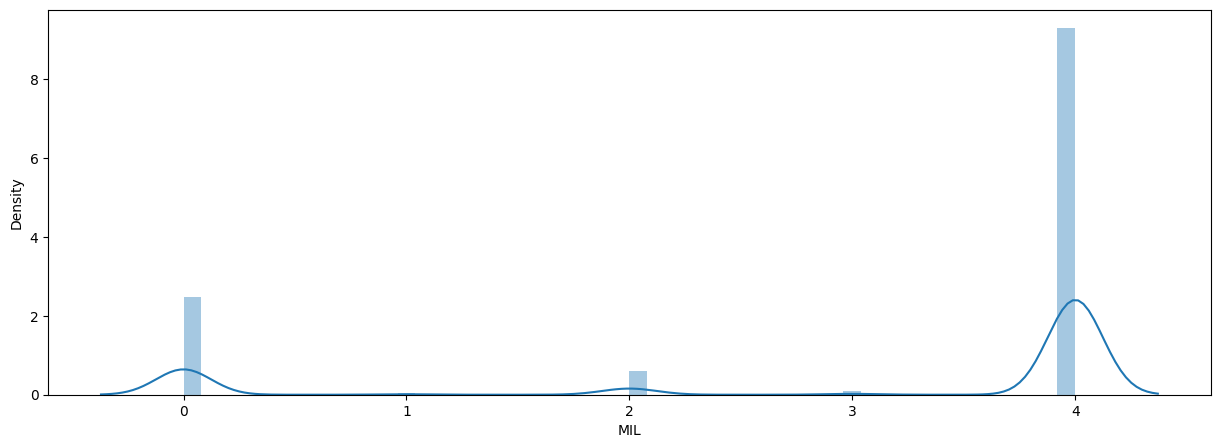

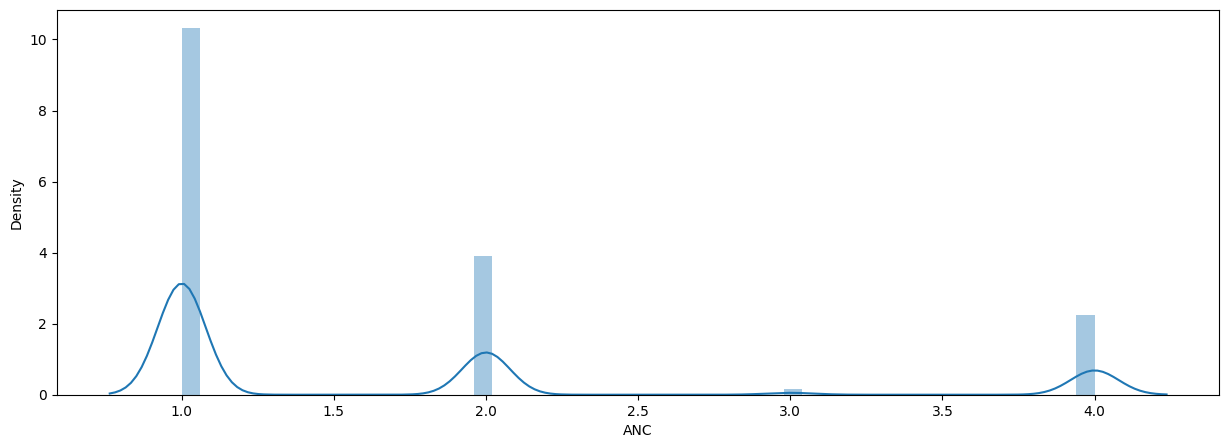

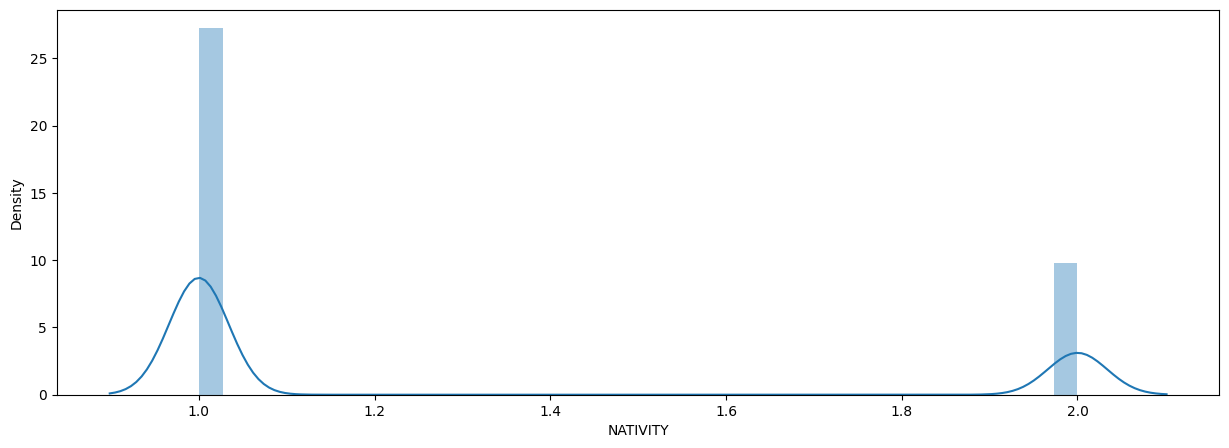

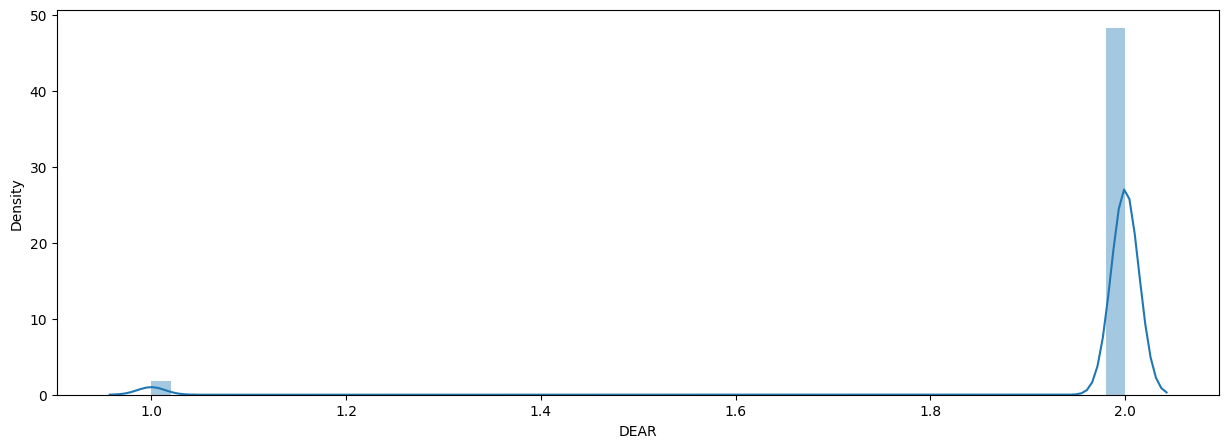

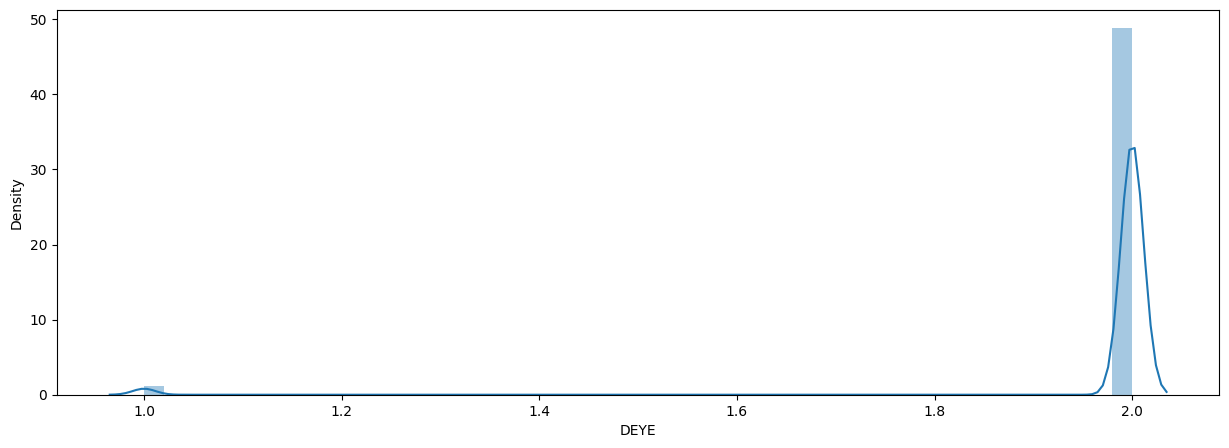

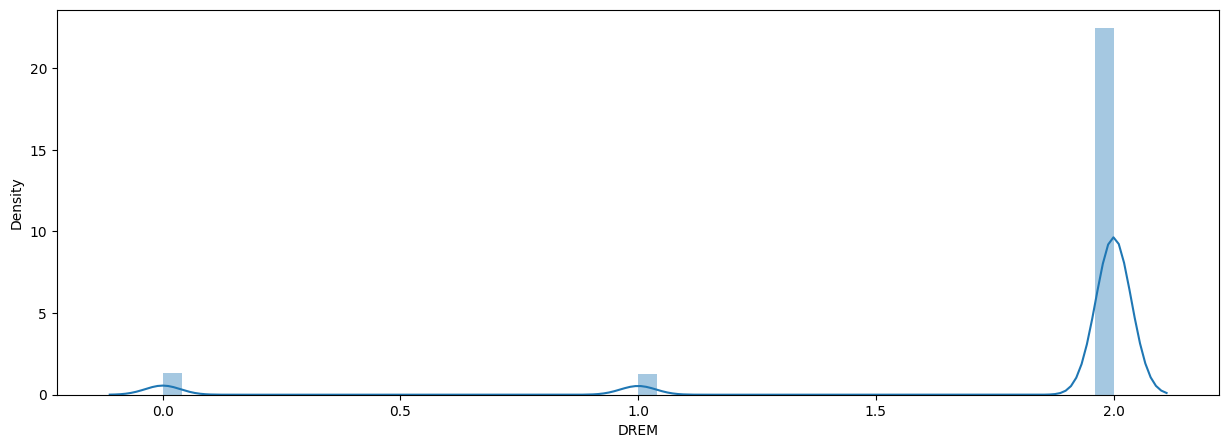

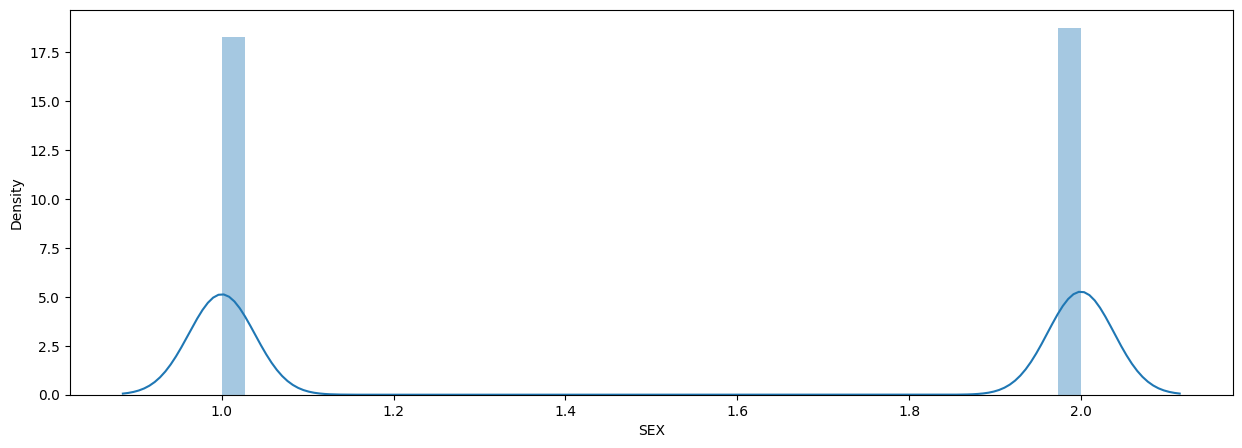

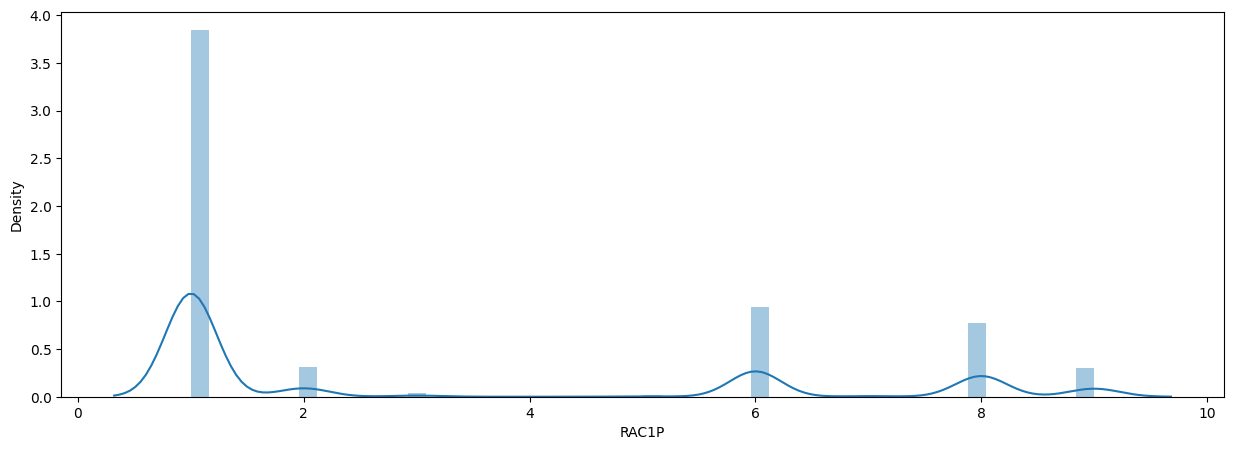

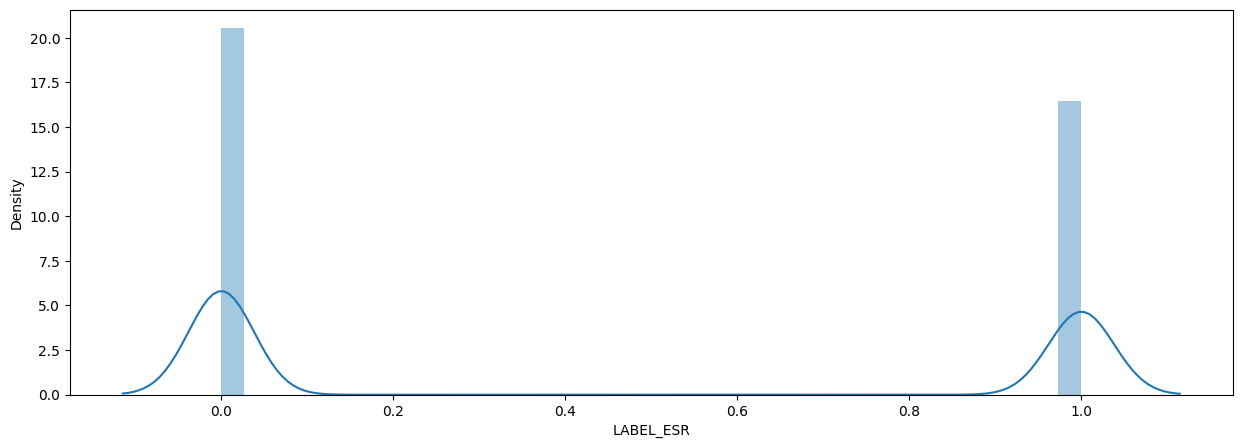

In [65]:
# Look at densities of each column
for column in full_df.columns:
    plt.figure()
    sns.distplot(full_df[column])

### Analyze Feature Importance

In [66]:
SEED = 42
features_df = full_df.drop('LABEL_ESR', axis=1, inplace=False)
target_df = full_df['LABEL_ESR']
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(features_df, target_df, test_size=0.2, random_state=SEED)
X_train_full.shape, X_test_full.shape

((300828, 16), (75207, 16))

Text(0.5, 0, 'Random Forest Feature Importance')

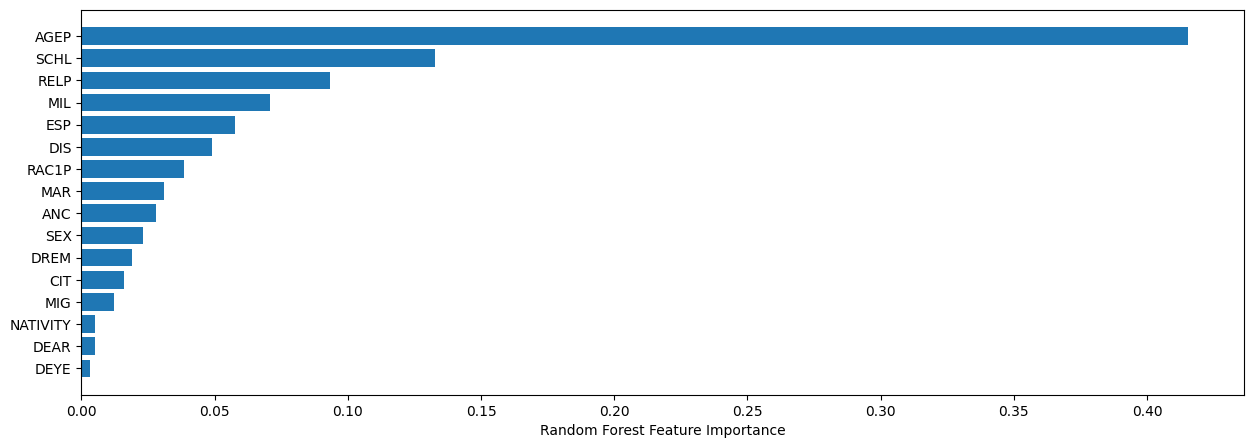

In [67]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_full, y_train_full)

sorted_idx = rf.feature_importances_.argsort()
plt.barh(features_df.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Correlation Analysis after One-Hot Encoding

In [68]:
feature_analysis_cols = [col for col in full_df.columns if col not in ['AGEP', 'SCHL']]
features_analysis_df = pd.get_dummies(full_df[feature_analysis_cols], columns=feature_analysis_cols)
features_analysis_df['AGEP'] = full_df['AGEP']
features_analysis_df['SCHL'] = full_df['SCHL']
features_analysis_df.head()

,MAR_1,MAR_2,MAR_3,MAR_4,MAR_5,RELP_0,RELP_1,RELP_2,RELP_3,RELP_4,...,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,LABEL_ESR_False,LABEL_ESR_True,AGEP,SCHL
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,68,20.0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,75,18.0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,50,19.0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,49,16.0
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,1,0,22,18.0


In [69]:
features_analysis_df.columns

Index(['MAR_1', 'MAR_2', 'MAR_3', 'MAR_4', 'MAR_5', 'RELP_0', 'RELP_1',
       'RELP_2', 'RELP_3', 'RELP_4', 'RELP_5', 'RELP_6', 'RELP_7', 'RELP_8',
       'RELP_9', 'RELP_10', 'RELP_11', 'RELP_12', 'RELP_13', 'RELP_14',
       'RELP_15', 'RELP_16', 'RELP_17', 'DIS_1', 'DIS_2', 'ESP_0.0', 'ESP_1.0',
       'ESP_2.0', 'ESP_3.0', 'ESP_4.0', 'ESP_5.0', 'ESP_6.0', 'ESP_7.0',
       'ESP_8.0', 'CIT_1', 'CIT_2', 'CIT_3', 'CIT_4', 'CIT_5', 'MIG_0.0',
       'MIG_1.0', 'MIG_2.0', 'MIG_3.0', 'MIL_0.0', 'MIL_1.0', 'MIL_2.0',
       'MIL_3.0', 'MIL_4.0', 'ANC_1', 'ANC_2', 'ANC_3', 'ANC_4', 'NATIVITY_1',
       'NATIVITY_2', 'DEAR_1', 'DEAR_2', 'DEYE_1', 'DEYE_2', 'DREM_0.0',
       'DREM_1.0', 'DREM_2.0', 'SEX_1', 'SEX_2', 'RAC1P_1', 'RAC1P_2',
       'RAC1P_3', 'RAC1P_4', 'RAC1P_5', 'RAC1P_6', 'RAC1P_7', 'RAC1P_8',
       'RAC1P_9', 'LABEL_ESR_False', 'LABEL_ESR_True', 'AGEP', 'SCHL'],
      dtype='object')

In [72]:
def get_column_correlations(column_list):
    for method in ['pearson', 'kendall', 'spearman']:
        ax = plt.axes()
        sns.heatmap(features_analysis_df[column_list].corr(method=method), ax=ax, annot=True)
        ax.set_title(f'{method.capitalize()} Correlation')
        plt.show()

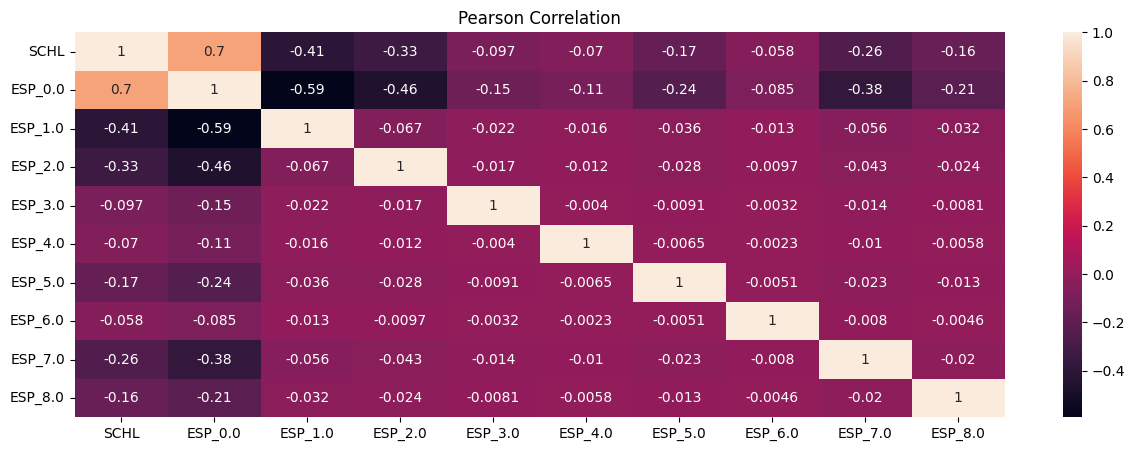

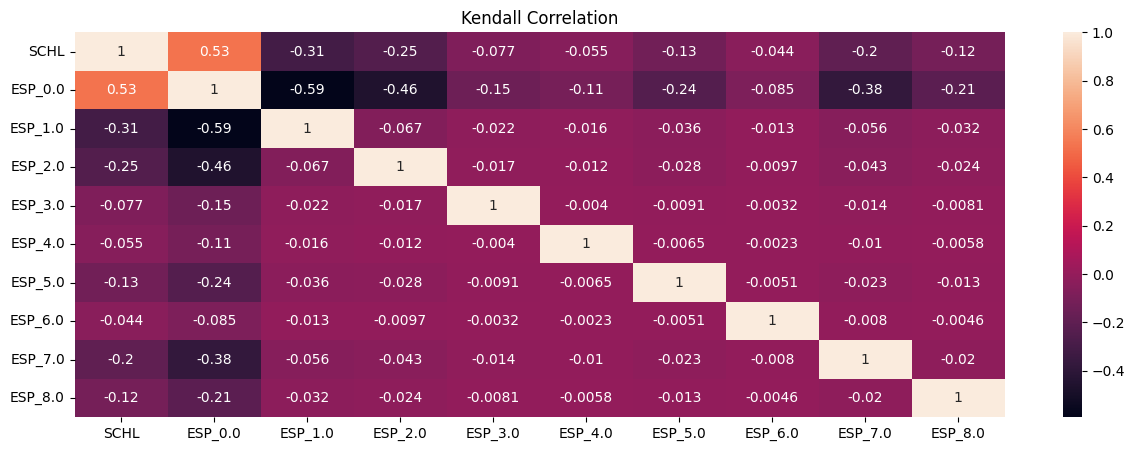

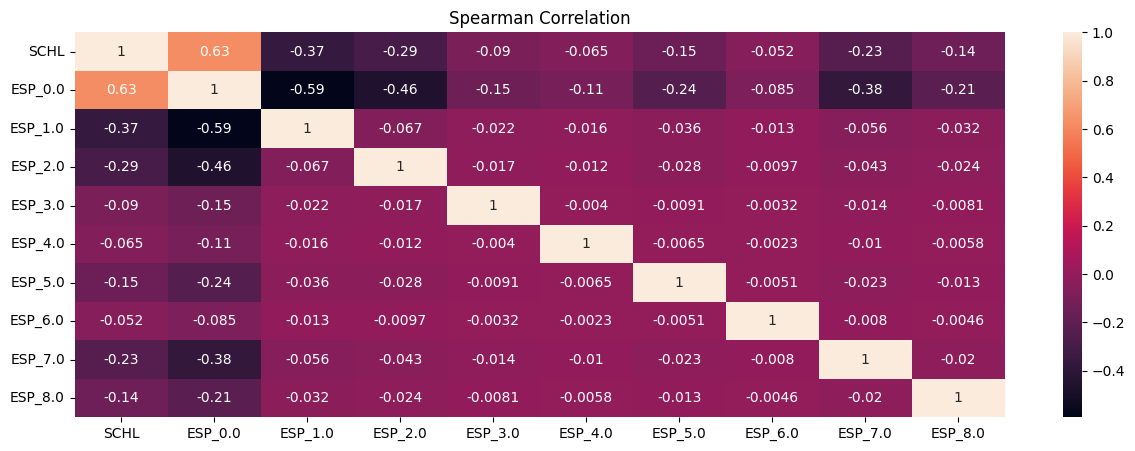

In [73]:
get_column_correlations(['SCHL', 'ESP_0.0', 'ESP_1.0', 'ESP_2.0', 'ESP_3.0', 'ESP_4.0', 'ESP_5.0', 'ESP_6.0', 'ESP_7.0', 'ESP_8.0'])

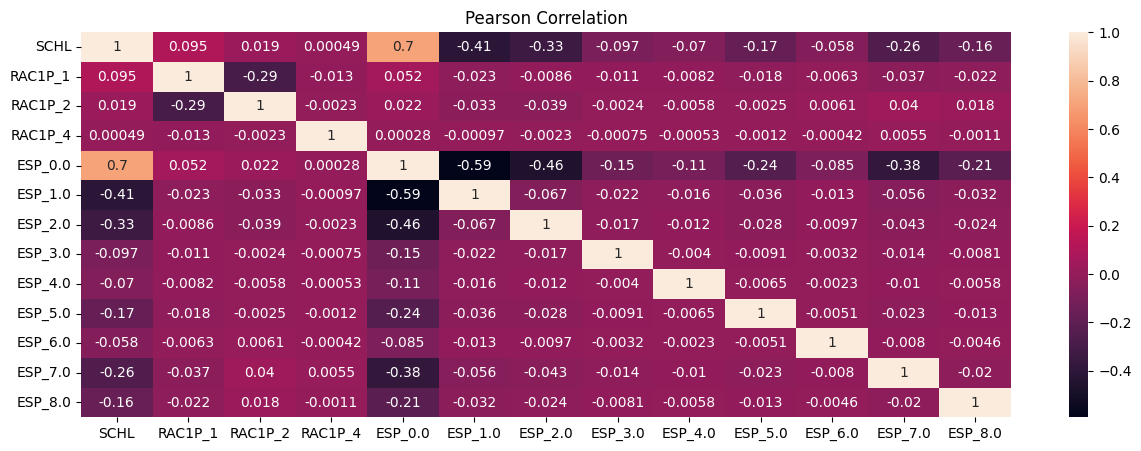

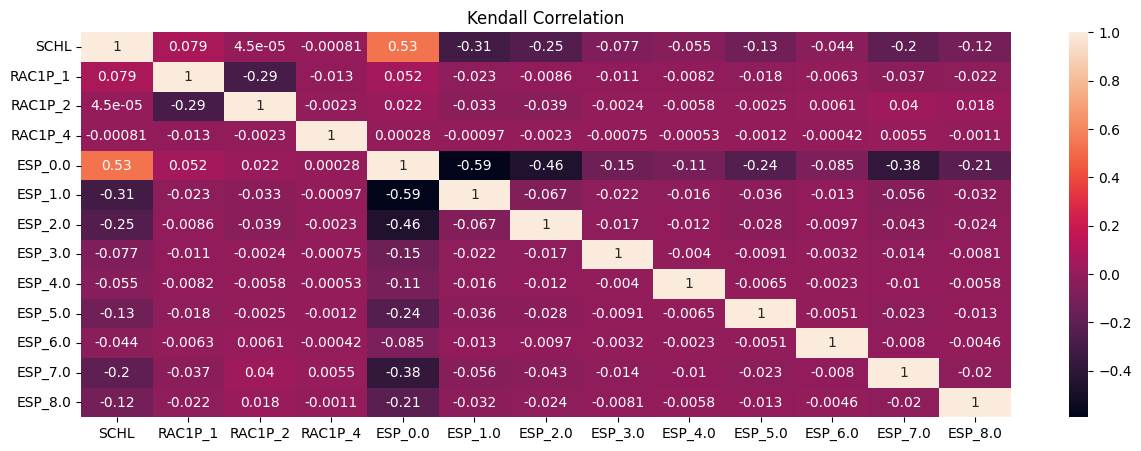

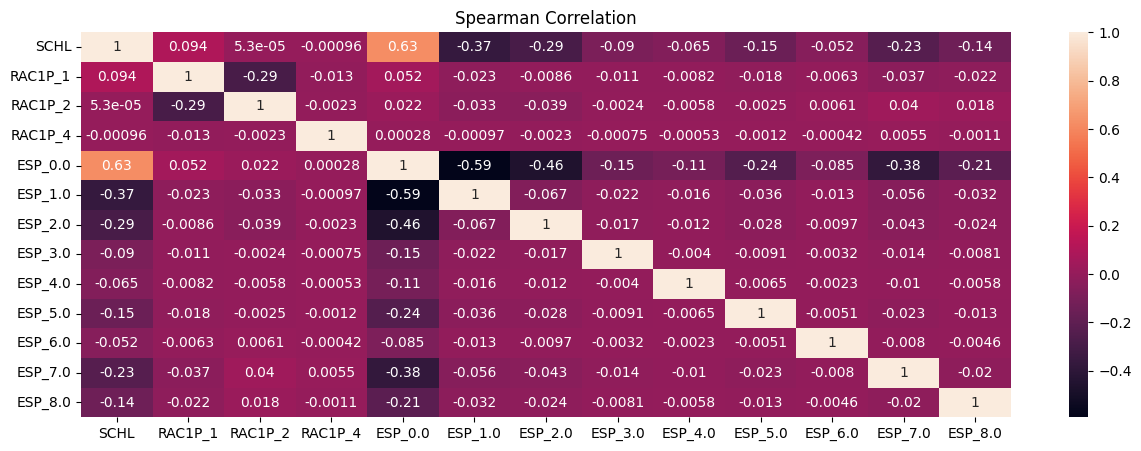

In [74]:
get_column_correlations(['SCHL', 'RAC1P_1', 'RAC1P_2', 'RAC1P_4', 'ESP_0.0', 'ESP_1.0',
                         'ESP_2.0', 'ESP_3.0', 'ESP_4.0', 'ESP_5.0', 'ESP_6.0', 'ESP_7.0', 'ESP_8.0'])

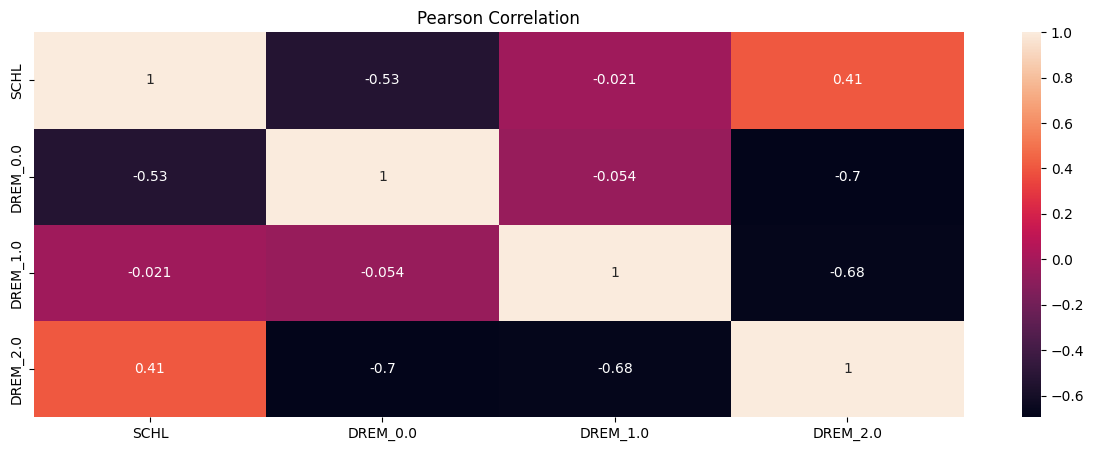

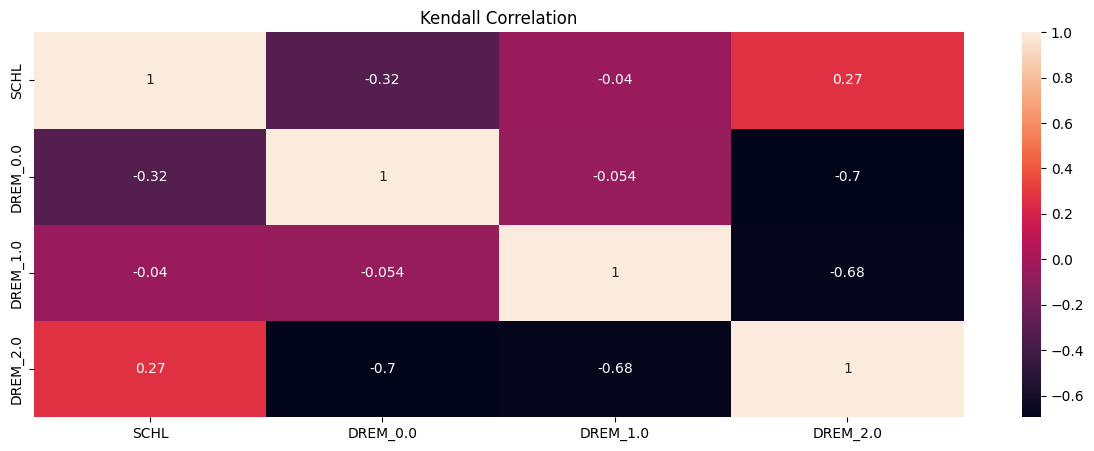

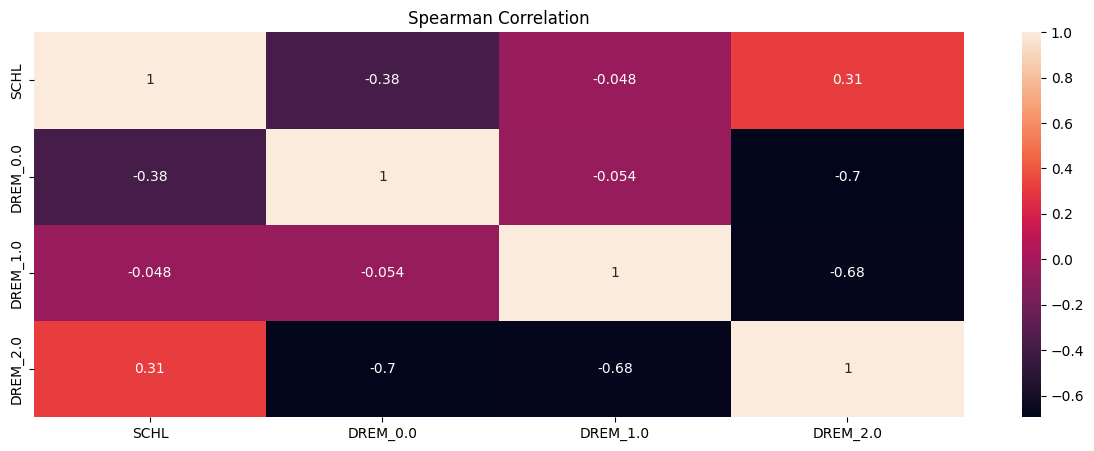

In [75]:
get_column_correlations(['SCHL', 'DREM_0.0', 'DREM_1.0', 'DREM_2.0'])

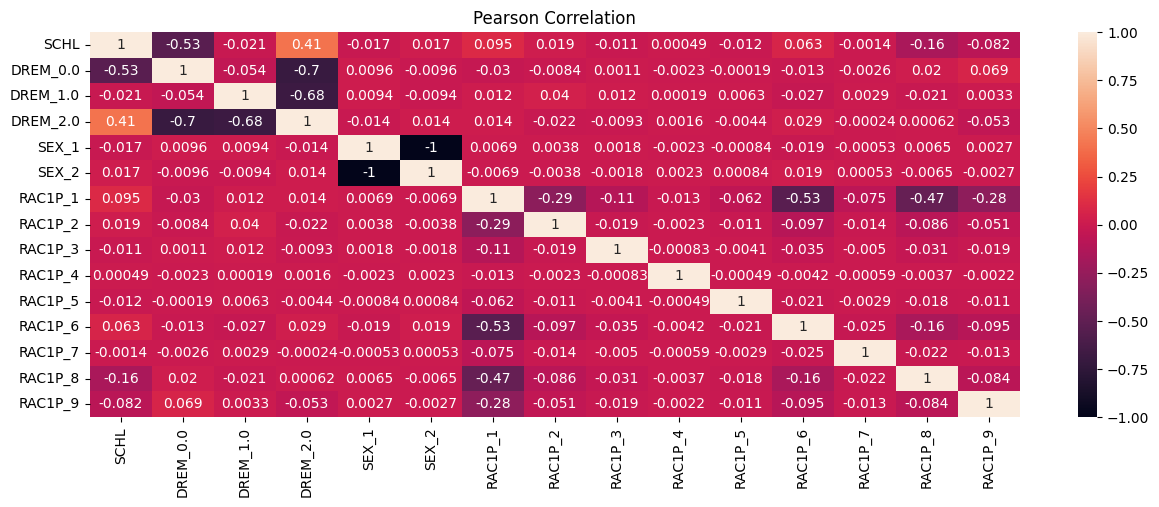

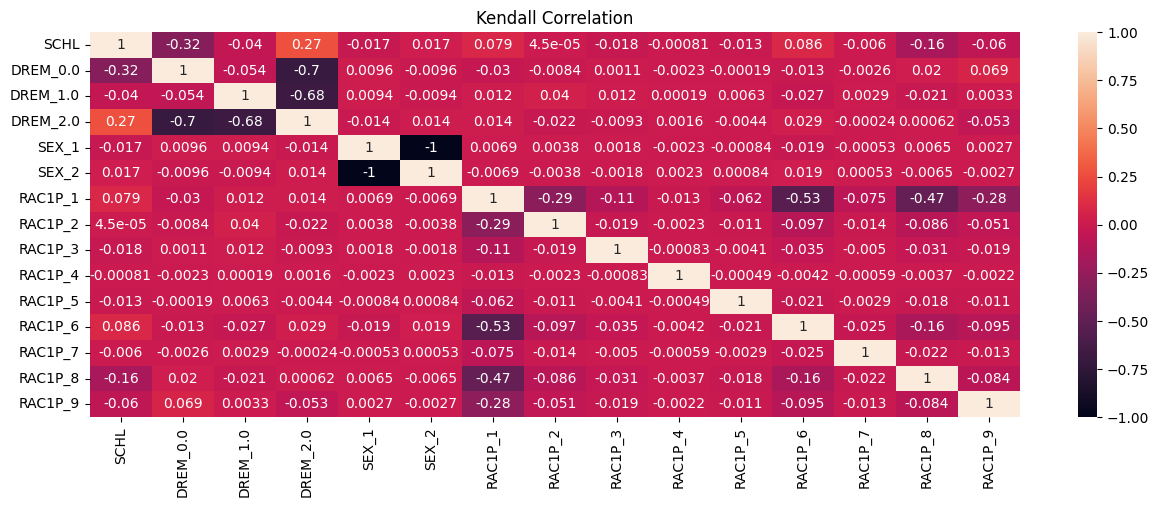

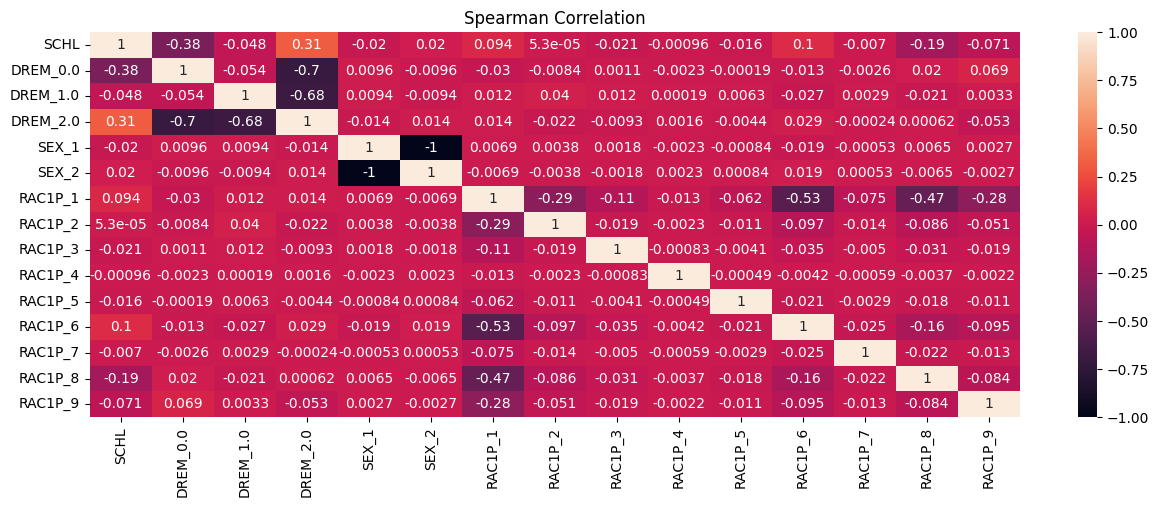

In [76]:
get_column_correlations(['SCHL', 'DREM_0.0', 'DREM_1.0', 'DREM_2.0', 'SEX_1', 'SEX_2', 'RAC1P_1', 'RAC1P_2',
                          'RAC1P_3', 'RAC1P_4', 'RAC1P_5', 'RAC1P_6', 'RAC1P_7', 'RAC1P_8', 'RAC1P_9'])

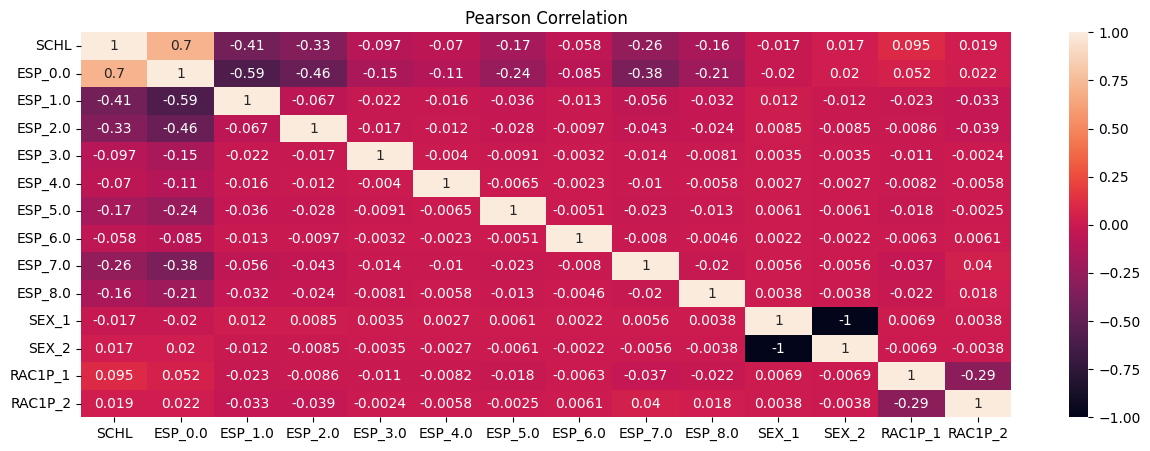

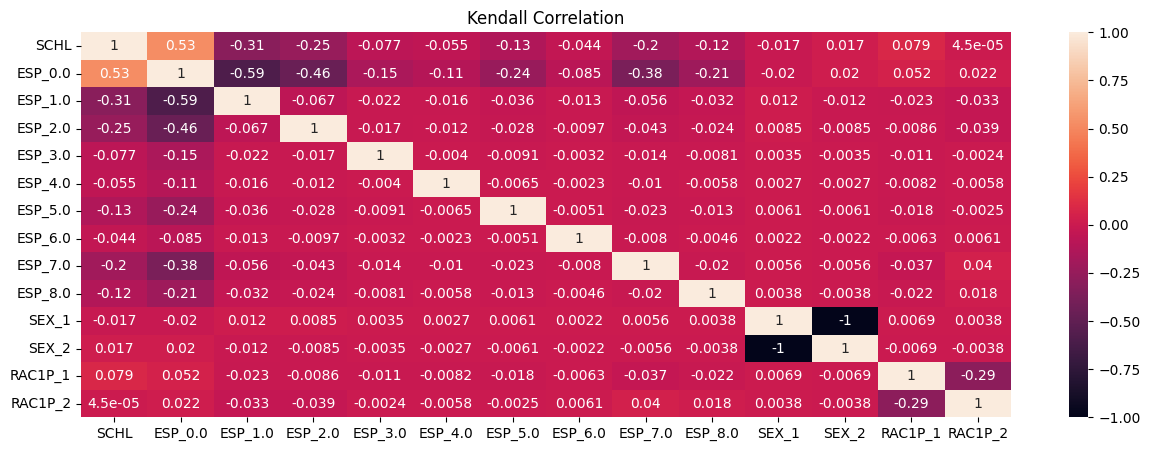

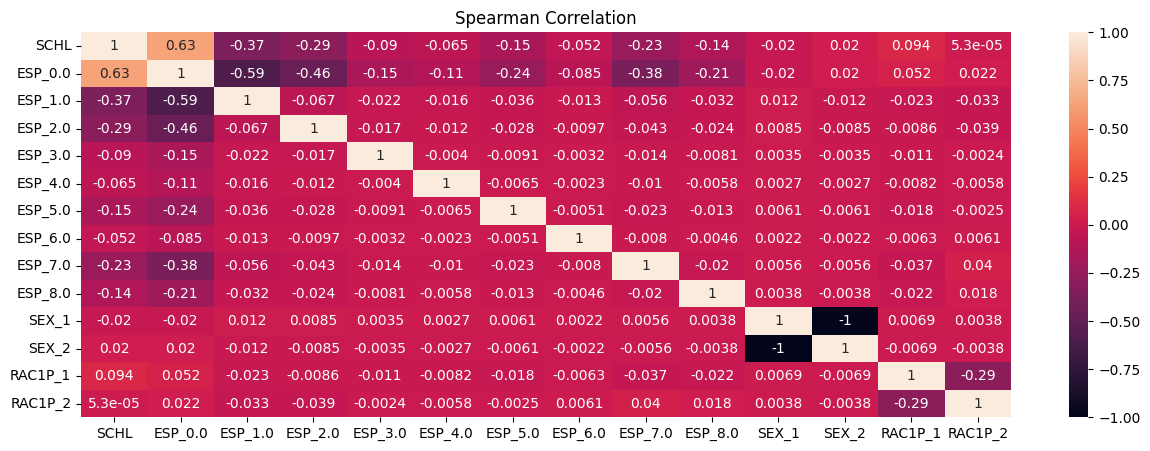

In [77]:
get_column_correlations(['SCHL', 'ESP_0.0', 'ESP_1.0', 'ESP_2.0', 'ESP_3.0', 'ESP_4.0', 'ESP_5.0', 'ESP_6.0',
                         'ESP_7.0','ESP_8.0', 'SEX_1', 'SEX_2', 'RAC1P_1', 'RAC1P_2'])

### Train a baseline model

In [ ]:
# Create a feature dataframe based on the feature correlation with 'LABEL_ESR' and feature importance
feature_cols = ['MIL', 'DIS', 'ESP', 'MAR', 'RELP', 'ANC']
features_df = pd.get_dummies(full_df[feature_cols], columns=feature_cols)
features_df['AGEP'] = full_df['AGEP']
features_df['SCHL'] = full_df['SCHL']
target_df = full_df['LABEL_ESR']
features_df.head()

In [ ]:
features_df.columns

In [22]:
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2, random_state=SEED)
X_train.shape, X_test.shape

((300828, 45), (75207, 45))

In [23]:
n_folds = 3
samples_per_fold = len(y_test)
best_results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                   'Accuracy_Score',
                                   'Model_Best_Params', 'Model_Pred'))

In [26]:
config_models = [
    {
        'model_name': 'RandomForestClassifier',
        'model': RandomForestClassifier(random_state=SEED),
        'params': {
            "bootstrap": [True],
            "max_depth": [10],
            "n_estimators": [30],
            "max_features": [0.6]
        }
    },
    {
        'model_name': 'DecisionTreeClassifier',
        'model': DecisionTreeClassifier(random_state=SEED),
        'params': {
            "max_depth": [10],
            "max_features": [0.6],
            "criterion": ["gini"]
        }
    },
    # For XGBoost parameters tuning we used this article --
    # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
    {
        'model_name': 'XGBClassifier',
        'model': XGBClassifier(random_state=SEED),
        'params': {
            'learning_rate': [0.1],
            'n_estimators': [200],
            'max_depth': [5],
            'objective':  ['binary:logistic'],
        }
    }
]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Tuning for RandomForestClassifier is finished
####################  Folktables [LA]  ####################
Test model:  RandomForestClassifier
Test model parameters:
{'bootstrap': True, 'max_depth': 10, 'max_features': 0.6, 'n_estimators': 30}

              precision    recall  f1-score   support

       False      0.884     0.759     0.817     41736
        True      0.745     0.876     0.805     33471

    accuracy                          0.811     75207
   macro avg      0.814     0.818     0.811     75207
weighted avg      0.822     0.811     0.812     75207



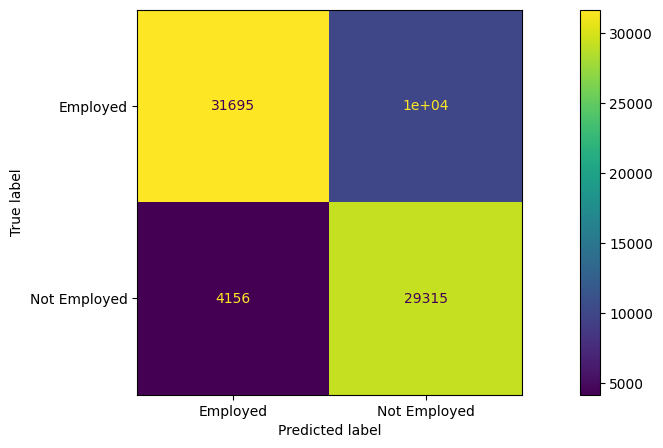

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Tuning for DecisionTreeClassifier is finished
####################  Folktables [LA]  ####################
Test model:  DecisionTreeClassifier
Test model parameters:
{'criterion': 'gini', 'max_depth': 10, 'max_features': 0.6}

              precision    recall  f1-score   support

       False      0.884     0.758     0.816     41736
        True      0.744     0.876     0.804     33471

    accuracy                          0.811     75207
   macro avg      0.814     0.817     0.810     75207
weighted avg      0.822     0.811     0.811     75207



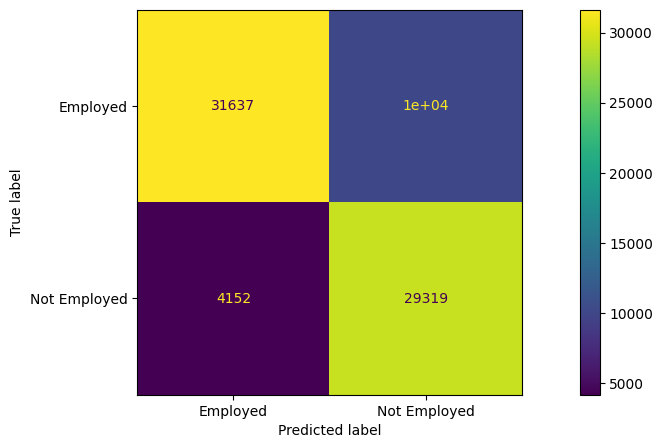

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Tuning for XGBClassifier is finished
####################  Folktables [LA]  ####################
Test model:  XGBClassifier
Test model parameters:
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 200,
 'objective': 'binary:logistic'}

              precision    recall  f1-score   support

       False      0.883     0.762     0.818     41736
        True      0.746     0.874     0.805     33471

    accuracy                          0.812     75207
   macro avg      0.815     0.818     0.811     75207
weighted avg      0.822     0.812     0.812     75207



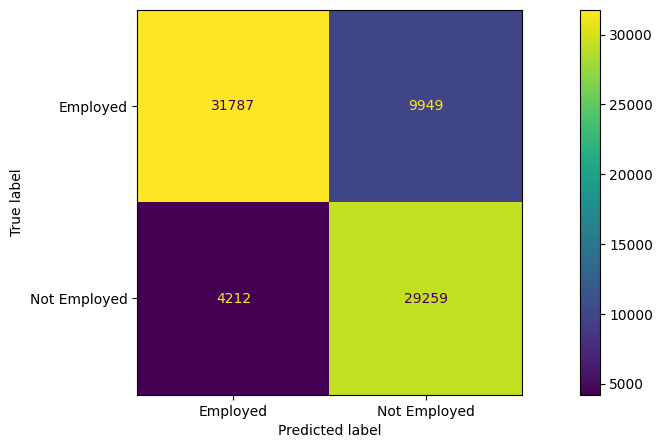

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,Folktables [LA],RandomForestClassifier,0.811038,0.811228,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
1,Folktables [LA],DecisionTreeClassifier,0.810329,0.810510,"{'criterion': 'gini', 'max_depth': 10, 'max_fe..."
2,Folktables [LA],XGBClassifier,0.811493,0.811706,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


In [27]:
ML_results_df = test_ML_models(best_results_df, config_models, n_folds, samples_per_fold,
                               X_train, y_train, X_test, y_test, "Folktables [LA]", show_plots=True, debug_mode=True)
ML_results_df

In [28]:
for index, row in ML_results_df.iterrows():
  print(f'\n\nModel name: {row["Model_Name"]}')
  pprint(row['Model_Best_Params'])



Model name: RandomForestClassifier
{'bootstrap': True, 'max_depth': 10, 'max_features': 0.6, 'n_estimators': 30}


Model name: DecisionTreeClassifier
{'criterion': 'gini', 'max_depth': 10, 'max_features': 0.6}


Model name: XGBClassifier
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 200,
 'objective': 'binary:logistic'}
